In [1]:
%pylab inline
import pandas as pd
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [2]:
%cat data/univ-latencies/license.txt

UsageError: Line magic function `%cat` not found.


In [3]:
df = pd.read_csv('data/univ-latencies/univ-latencies.txt')

In [24]:
df

,acu-edu,acadiau-ca,adrian-edu,agnesscott-edu,aims-edu,uni-freiburg-de,alfred-edu,alvernia-edu,alverno-edu,american-edu,...,williams-edu,wsc-nodak-edu,winona-msus-edu,wpi-edu,wright-edu,yale-edu,yu-edu,yorku-ca,upenn-edu,ens-fr
0,396,381,488,506,333,1327,132,70,456,121,...,220,1898,434,125,304,94,460,347,532,429
1,271,261,488,504,276,1084,89,23,409,34,...,263,1032,294,74,269,252,98,265,233,293
2,271,141,325,545,266,1078,86,27,837,33,...,409,891,292,77,288,41,78,261,114,300
3,268,136,324,1946,331,1342,88,24,531,35,...,361,421,298,76,228,42,153,266,322,532
4,273,136,321,549,290,1192,143,26,434,32,...,982,522,296,73,764,41,98,262,234,271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,285,136,284,352,257,1058,84,23,418,646,...,137,888,301,71,196,40,95,244,151,297
1357,282,137,286,380,257,4723,108,24,399,33,...,138,442,291,72,197,39,85,261,138,260
1358,263,137,285,317,258,1756,85,24,394,33,...,132,339,299,90,196,40,80,246,139,261
1359,266,136,349,364,264,1078,83,23,630,33,...,141,366,293,98,197,39,154,261,148,274


In [4]:
print("Latency of some homepages in the first timesteps")
df.iloc[:10,:5]

Latency of some homepages in the first timesteps


,acu-edu,acadiau-ca,adrian-edu,agnesscott-edu,aims-edu
0,396,381,488,506,333
1,271,261,488,504,276
2,271,141,325,545,266
3,268,136,324,1946,331
4,273,136,321,549,290
5,268,144,543,545,284
6,271,142,290,472,275
7,316,136,339,2162,372
8,268,136,286,464,263
9,531,409,320,470,315


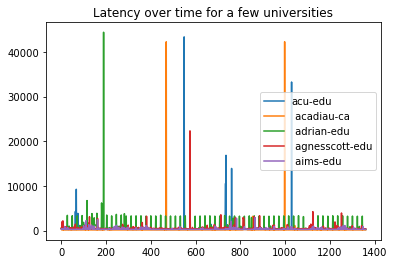

In [5]:
df.iloc[:,:5].plot(title='Latency over time for a few universities')

The dataset is transformed so as to come back to a Bernoulli problem. The reward is:
- 1 if latency is < threshold
- 0 if latency is > threshold

for an arbitrary latency threshold.

The task boils down to exploring which universities have the lowest latency and exploiting this knowledge to minimize the sum of latencies until the end of the experiment.

In [6]:
print("Mean reward for a few arms")
(df.iloc[:,:5] > 500).astype(int).mean()

Mean reward for a few arms


acu-edu            0.021308
 acadiau-ca        0.016899
 adrian-edu        0.131521
 agnesscott-edu    0.146216
 aims-edu          0.069067
dtype: float64

In [7]:
def get_dataset(n_arms, n_steps=None, max_latency=None, quantile=.5, shuffle=True):
    """
    return a binary dataset.
    
    n_arms: nb of pullable arms
    max_latency: criteria to decide if latency is good/bad (default: inferred from quantile)
    quantile: proportion of "1" labels
    """
    df = pd.read_csv('data/univ-latencies/univ-latencies.txt')
    if n_arms > df.shape[1]:
        raise Exception("Please specify max %d arms" % df.shape[1])
    if max_latency is None:
        max_latency = df.iloc[:,:n_arms].mean().quantile(quantile)
    raw_vector = (df.iloc[:,:n_arms] < max_latency).astype(int)
    if shuffle:
        raw_vector = raw_vector.sample(frac=1)
    if n_steps is None:
        return raw_vector
    if raw_vector.shape[0] > n_steps:
        return raw_vector.iloc[:n_steps-1,:]
    v = raw_vector.sample(n=n_steps, replace=True, random_state=42)
    v.index = np.arange(v.shape[0])
    return v

In [8]:
def adversarialize(ddf, nb_episods=2):
    ddf = ddf.copy()
    episod_len = int(ddf.shape[0]/nb_episods)
    #print("len", ddf.shape[0], "epilen", episod_len)
    for _ in range(nb_episods):
        start = _*episod_len
        end = min((_+1)*episod_len, ddf.shape[0])
        #print("epi", _, start, end)
        for col in range(ddf.shape[1]):
            ddf.iloc[start:end,col] = np.sort(ddf.iloc[start:end,col])
            if np.random.randint(0,2) > 0:
                ddf.iloc[start:end,col] = np.flip(ddf.iloc[start:end,col])
    ddf.index = np.arange(ddf.shape[0])
    return ddf

In [9]:
get_dataset(5, quantile=.5).mean()

acu-edu            0.964732
 acadiau-ca        0.980162
 adrian-edu        0.788391
 agnesscott-edu    0.467303
 aims-edu          0.907421
dtype: float64

# Provided Code

## Bandit API

In [10]:
class Bandit():
    def __init__(self, n_arms):
        self.n_arms = n_arms
    def pull(self) -> int:
        """Choose an arm."""
        raise NotImplemented()
    def feedback(self, arm: int, reward):
        """Process feedback"""
        raise NotImplemented()

In [11]:
def test_API(bandit_class):
    bandit = bandit_class(2)
    arm = bandit.pull()
    assert type(arm) in (int, np.int, np.int16, np.int32, np.int64), type(arm)
    bandit.feedback(0, 0)
    bandit.feedback(0, 1)
    bandit.feedback(1, 0)
    bandit.feedback(1, 1)
    print(bandit_class.__name__ + " sounds correct.")

## Given Bandit Implems

In [12]:
class EpsilonGreedy(Bandit):
    def __init__(self, n_arms, epsilon=.1):
        Bandit.__init__(self, n_arms)
        self.epsilon = epsilon
        self.reward_sum_per_arm = np.zeros(n_arms)
        self.actions_per_arm = np.zeros(n_arms)
    def pull(self) -> int:
        unpulled_arms = [_ for _ in range(self.n_arms) if self.actions_per_arm[_] < 1]
        if len(unpulled_arms):
            return np.random.choice(unpulled_arms)
        if np.random.random() < self.epsilon:
            arm = np.random.choice(np.arange(self.n_arms))
            return arm
        arms_weights = self.reward_sum_per_arm / self.actions_per_arm
        return np.argmax(arms_weights)
    def feedback(self, arm: int, reward):
        self.actions_per_arm[arm] += 1
        self.reward_sum_per_arm[arm] += reward

In [13]:
class WeightedRandomBandit(Bandit):
    """Play a random action according to $\hat{X_{i,t}}$."""
    def __init__(self, n_arms):
        Bandit.__init__(self, n_arms)
        self.reward_sum_per_arm = np.zeros(n_arms)
        self.actions_per_arm = np.zeros(n_arms)        
    def pull(self) -> int:
        unpulled_arms = [_ for _ in range(self.n_arms) if self.actions_per_arm[_] < 10]
        if len(unpulled_arms):
            return np.random.choice(unpulled_arms)
        arms_weights = self.reward_sum_per_arm / self.actions_per_arm
        arms_weights = arms_weights / np.sum(arms_weights)
        return np.random.choice(self.n_arms, p=arms_weights)
    def feedback(self, arm: int, reward):
        self.actions_per_arm[arm] = self.actions_per_arm[arm] + 1
        self.reward_sum_per_arm[arm] = self.reward_sum_per_arm[arm] + reward

In [14]:
class Experiment():
    """Given a Bandit, run an experiment and compute regret."""
    
    def __init__(self, n_arms:int, n_steps:int, adversarial:int=0):
        # data
        self.n_arms = n_arms
        self.data = get_dataset(n_arms, n_steps=n_steps)
        if adversarial > 0:
            self.data = adversarialize(self.data, nb_episods=adversarial)
        self.n_turns = self.data.shape[0]
        # regret analysis variables
        self.actions = []
        self.rewards = []
        self.stochastic_regrets = []
        # algo analysis variables
        self.actions_per_arm = np.zeros(self.n_arms)
        self.reward_sum_per_arm = np.zeros(self.n_arms)
        self.exploration = []
        
    def run(self, b: Bandit):
        for t in range(self.data.shape[0]):
            # bandit action
            chosen_arm = b.pull()
            reward = self.data.iloc[t, chosen_arm]
            b.feedback(chosen_arm, reward)
            # regret data gathering
            self.actions += [chosen_arm]
            self.actions_per_arm[chosen_arm] += 1
            self.rewards += [reward]
            self.stochastic_regrets += [self.data.iloc[t,self.best_arm] - reward]
            # algo data gathering
            self.reward_sum_per_arm[chosen_arm] += reward
            arms_perceived_performance = self.reward_sum_per_arm / (self.actions_per_arm + 1e-9)
            best_looking_arm = np.argmax(arms_perceived_performance)
            is_exploration = 0 if np.abs(arms_perceived_performance[best_looking_arm] - arms_perceived_performance[chosen_arm]) < 1e-5 else 1
            self.exploration += [is_exploration]
        return self
            
    # Regret metrics
    
    @property
    def best_arm(self):
        return np.argmax(self.data.mean().values)
    
    @property
    def worst_arm(self):
        return np.argmin(self.data.mean().values)

    @property
    def delta_perf(self):
        return self.data.iloc[:,self.best_arm].mean() - self.data.iloc[:,self.worst_arm].mean()
    
    @property
    def best_arm_cumulated_reward(self):
        return self.data.iloc[:,self.best_arm].sum()

    @property
    def best_arm_mean_reward(self):
        return self.data.iloc[:,self.best_arm].mean()
    
    @property
    def cumulated_stochastic_regret(self):
        return self.best_arm_cumulated_reward - np.sum(self.reward_sum_per_arm)
    
    @property
    def mean_reward(self):
        return np.mean(self.rewards)

    @property
    def mean_stochastic_regret(self):
        return self.best_arm_mean_reward - self.mean_reward

    @property
    def n_exploration_pulls(self):
        return np.sum(self.exploration)

    @property
    def exploration_pull_ratio(self):
        return self.n_exploration_pulls / float(self.n_turns)

    def stochastic_regret_summary(self):
        return pd.DataFrame(data={
                'E[R]': [self.mean_stochastic_regret],
                'E[Delta]': [self.delta_perf],
                'Rn': [self.cumulated_stochastic_regret],
            })
    
    def cumulated_regret_summary(self):
        rng = pd.date_range('1/1/2011', periods=len(self.stochastic_regrets), freq='600s')
        ts = pd.DataFrame(data={
                'cumulated_stochastic_regret': np.cumsum(self.stochastic_regrets), 
                'cumulated_exploration': np.cumsum(self.exploration), 
            }, index=rng)
        return ts
    
    # algorithm metrics
    
    def arm_plays_summary(self):
        true_means = self.data.mean()
        comp = pd.DataFrame(pd.concat([
                    true_means, 
                    pd.Series(self.actions_per_arm, index=true_means.index),
                    pd.Series(self.reward_sum_per_arm/self.actions_per_arm, index=true_means.index),
                ], axis=1).values, columns=['true_mean_reward', 'pull_count', 'observed_mean_reward'])
        return comp.sort_values(by='true_mean_reward')

# Experiments

## 1. [Warm-up] Study of Epsilon Greedy

In [78]:
n_arms=10
n_steps=1000
exp = Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms))
exp.stochastic_regret_summary()

,E[R],E[Delta],Rn
0,0.035035,0.991992,35.0


In [25]:
n_arms=10
n_steps=1000
exp = Experiment(n_arms, n_steps).run(WeightedRandomBandit(n_arms))
exp.stochastic_regret_summary()

,E[R],E[Delta],Rn
0,0.117117,0.992993,117.0


### 1.1 parameters of Epsilon Greedy

Text(0, 0.5, 'E[R]')

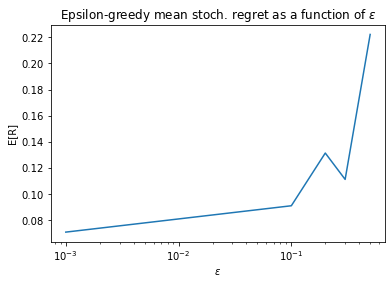

In [42]:
n_arms=10
n_steps=100
epsilons = [.001, .01, .1, .2, .3, .5]
mean_regrets = [
    Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms, epsilon=eps)).stochastic_regret_summary()['E[R]'].values 
    for eps in epsilons
]

plt.semilogx(epsilons, mean_regrets)
plt.title('Epsilon-greedy mean stoch. regret as a function of $\epsilon$')
plt.xlabel('$\epsilon$')
plt.ylabel('E[R]')

### 1.2 Comparing regret in the stochastic case

In [43]:
# Experiment parameters
n_arms = 10
n_repeats = 30
n_steps = 1000
# Algos to test 
bandit_classes = [EpsilonGreedy, WeightedRandomBandit]
bandit_params = [{'epsilon':.02}, {}]
# Metric to evaluate performance
stochastic_regret = defaultdict(list)
# Run the experiments
for _ in range(n_repeats):
    for bandit_class, bandit_param in zip(bandit_classes, bandit_params):
        exp = Experiment(n_arms, n_steps)
        exp.run(bandit_class(n_arms, **bandit_param))
        stochastic_regret[bandit_class.__name__] += [exp.mean_stochastic_regret]
# Results
for bandit_class in bandit_classes:
    print("E[R] CI for", bandit_class.__name__, ":", 
          np.percentile(stochastic_regret[bandit_class.__name__], [.05, .95]))

E[R] CI for EpsilonGreedy : [0.00705055 0.00783433]
E[R] CI for WeightedRandomBandit : [0.09310761 0.09336887]


In [18]:
Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms)).exploration_pull_ratio

0.0960960960960961

In [19]:
Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms)).arm_plays_summary()

,true_mean_reward,pull_count,observed_mean_reward
5,0.000000,14.0,0.000000
8,0.001001,9.0,0.000000
3,0.199199,11.0,0.181818
2,0.680681,20.0,0.750000
4,0.895896,14.0,0.928571
0,0.955956,12.0,0.833333
6,0.966967,16.0,0.937500
9,0.973974,38.0,0.973684
1,0.976977,843.0,0.975089
7,0.990991,22.0,0.954545


### 1.3 Cumulated Regret behavior

In [20]:
n_arms=10
n_steps=10**4

     E[R]  E[Delta]     Rn
0  0.0326    0.9933  326.0


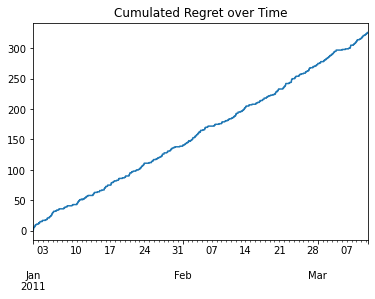

In [21]:
exp = Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms, epsilon=.1))
print(exp.stochastic_regret_summary())
cumul_data = exp.cumulated_regret_summary()
cumul_data['cumulated_stochastic_regret'].plot(title='Cumulated Regret over Time')

In [22]:
class MyBandit(Bandit):
    def __init__(self, n_arms):
        pass
    def pull(self) -> int:
        return 0
    def feedback(self, arm: int, reward):
        pass

In [ ]:
class EpsilonGreedy(Bandit):
    def __init__(self, n_arms, epsilon=.1):
        Bandit.__init__(self, n_arms)
        self.epsilon = epsilon
        self.reward_sum_per_arm = np.zeros(n_arms)
        self.actions_per_arm = np.zeros(n_arms)
    def pull(self) -> int:
        unpulled_arms = [_ for _ in range(self.n_arms) if self.actions_per_arm[_] < 1]
        if len(unpulled_arms):
            return np.random.choice(unpulled_arms)
        if np.random.random() < self.epsilon:
            arm = np.random.choice(np.arange(self.n_arms))
            return arm
        arms_weights = self.reward_sum_per_arm / self.actions_per_arm
        return np.argmax(arms_weights)
    def feedback(self, arm: int, reward):
        self.actions_per_arm[arm] += 1
        self.reward_sum_per_arm[arm] += reward

In [89]:
import math
class UCB(Bandit):
    def __init__(self, n_arms):
        Bandit.__init__(self, n_arms)
        self.reward_sum_per_arm = np.zeros(n_arms)
        self.actions_per_arm = np.zeros(n_arms)
    def pull(self) -> int:
        unpulled_arms = [_ for _ in range(self.n_arms) if self.actions_per_arm[_] < 1]
        t = 0
        if len(unpulled_arms):
            t = t+1
            return np.random.choice(unpulled_arms)
        
        for i in range(0, self.n_arms):
            if (self.actions_per_arm[i] > 0):
                average_reward = self.reward_sum_per_arm[i] / self.actions_per_arm[i]
                delta_i = math.sqrt(2 * math.log(t+1) / self.actions_per_arm[i])
                upper_bound = average_reward + delta_i
                arm = np.argmax(upper_bound)
                return arm

        arms_weights = self.reward_sum_per_arm / self.actions_per_arm
    def feedback(self, arm: int, reward):
        self.actions_per_arm[arm] += 1
        self.reward_sum_per_arm[arm] += reward

In [ ]:
class UCB(Bandit):
    def __init__(self, n_arms):
        Bandit.__init__(self, n_arms)
        self.reward_sum_per_arm = np.zeros(n_arms)
        self.actions_per_arm = np.zeros(n_arms)
    def pull(self) -> int:
        unpulled_arms = [_ for _ in range(self.n_arms) if self.actions_per_arm[_] < 1]
        if len(unpulled_arms):
            random_unpulled_arm = np.random.choice(unpulled_arms)
            return random_unpulled_arm
        exploit_incentive = self.reward_sum_per_arm / self.actions_per_arm
        explore_incentive = np.sqrt(2*np.log(np.sum(self.actions_per_arm)) / self.actions_per_arm)
        return np.argmax(exploit_incentive + explore_incentive)
    def feedback(self, arm: int, reward: int):
        assert reward in (0,1), reward
        self.actions_per_arm[arm] = self.actions_per_arm[arm] + 1
        self.reward_sum_per_arm[arm] = self.reward_sum_per_arm[arm] + reward
        
class ThompsonSampling(Bandit):
    def __init__(self, n_arms):
        Bandit.__init__(self, n_arms)
        self.success_per_arm = np.zeros(n_arms)
        self.failures_per_arm = np.zeros(n_arms)
        self.alpha = 1 
        self.beta = self.alpha # uniform prior
    def pull(self) -> int:
        arms_weights = [np.random.beta(self.alpha + self.success_per_arm, self.beta + self.failures_per_arm)]
        return np.argmax(arms_weights)
    def feedback(self, arm: int, reward):
        if reward == 0:
            self.failures_per_arm[arm] += 1
        else:
            self.success_per_arm[arm] += reward

In [94]:
n_arms=10
n_steps=1000
exp = Experiment(n_arms, n_steps).run(UCB(n_arms))
exp.stochastic_regret_summary()

,E[R],E[Delta],Rn
0,0.041041,0.991992,41.0
